# Tensor Factorisation in Keras

I have written a [few](../nnmf-tensorflow.html) [posts](../nmf-autograd.html) [earlier](../nmf-cvx.html) [about](../nmf-out-matrix.html) [matrix](../mf-autograd-adagrad.html) [factorisation](../contrained-nmf-cvx.html) [using](../nmf-nnls.html) various Python libraries. The main application I had in mind for matrix factorisation was [recommender systems](https://en.wikipedia.org/wiki/Recommender_system). In this post, I'll write about using [Keras](https://keras.io) for creating recommender systems. [Various](https://github.com/maciejkula/triplet_recommendations_keras) [people](http://blog.richardweiss.org/2016/09/25/movie-embeddings.html) [have](https://github.com/bradleypallen/keras-movielens-cf) [written](https://github.com/hexiangnan/neural_collaborative_filtering) [excellent](https://github.com/sonyisme/keras-recommendation) [similar](http://course.fast.ai/lessons/lesson4.html) [posts](https://github.com/maciejkula/spotlight) and code that I draw a lot of inspiration from, and give them their credit! I'm assuming that a reader has some experience with Keras, as this post is not intended to be an introduction to Keras.

Specifically, in this post, I'll talk about:

1. Matrix Factorisation in Keras
2. Adding non-negativitiy constraints to solve non-negative matrix factorisation (NNMF)
3. Using neural networks for recommendations

I'll be using the Movielens-100k dataset for illustration. There are 943 users and 1682 movies. In total there are a 100k ratings in the dataset. It should be noted that the max. total number of rating for the <users, movies> would be 943*1682, which means that we have about 7% of the total ratings! All rating are on a scale of 1-5. 

### **Task**

Given this set of ratings, can we recommend the next set of movies to a user? This would translate to: for every user, estimating the ratings for all the movies that (s)he hasn't watched and maybe recommend the top-k movies by the esimtated ratings! 

### Peak into the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [9]:
np.tensordot(x, y, axes=1).shape

ValueError: shape-mismatch for sum

In [11]:
x = np.random.randn(100, 3)
y = np.random.randn(70, 3)
z = np.random.randn(80, 3)

t_1 = np.tensordot(np.tensordot(x, y, axes=[1, 1]), z, axes=[1,1])
t_2 = np.einsum('xr, yr, zr ->xyz', x, y, z)
np.allclose(t_1, t_2)


ValueError: shape-mismatch for sum

In [22]:
np.tensordot(x, y, axes=[[0, 1],[0,1]]).shape

ValueError: shape-mismatch for sum

So, each record (row) shows the rating for a user, item (movie) pair. It should be noted that I use  item and movie interchangeably in this post.

In [5]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [6]:
dataset.head()

,user_id,item_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


### Train test split

We'll now split our dataset of 100k ratings into train (containing 80k ratings) and test (containing 20k ratings). Given the train set, we'd like to accurately estimate the ratings in the test set.

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

In [8]:
train.head()

,user_id,item_id,rating,timestamp
36694,460,254,2,885355890
12110,227,203,3,889388662
4933,4,240,1,875720948
98491,928,97,5,879640394
25545,453,403,3,888267590


In [9]:
test.head()

,user_id,item_id,rating,timestamp
77402,891,228,3,886610011
16503,369,658,4,879435033
28080,199,178,4,884129029
84580,652,355,1,880151734
36995,331,894,5,887916385


### Matrix factorisation

One popular recommender systems approach is called Matrix Factorisation. It works on the principle that we can learn a low-dimensional representation (embedding) of user and movie. For example, for each movie, we can have how much action it has, how long it is, and so on. For each user, we can encode how much they like action, or how much they like long movies, etc. Thus, we can combine the user and the movie embeddings to estimate the ratings on unseen movies. This approach can also be viewed as: given a matrix (A [M X N]) containing users and movies, we want to estimate low dimensional matrices (W [M X k] and H [M X k]), such that: $A \approx W.H^T$

### Matrix factorisation in Keras

We'll now write some code to solve the recommendation problem by matrix factorisation in Keras. We're trying to learn two low-dimensional embeddings of users and items.




In [53]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 3

The key thing is to learn an embedding for movies and users, and then combine them using the dot product! For estimating the rating, for each user, movie pair of interest, we'd take the dot product of the respective user and item embedding. As an example, if we have 2 dimensions in our user and item embedding, which say correspond to [how much user likes action, how much user likes long movies], and the item embedding is [how much action is in the movie, how long is the movie]. Then, we can predict for a user `u`, and movie `m` as how much `u` likes action $\times$ how much action is there in `m` $+$ how much `u` likes long movies $\times$ how long is `m`.

Our model would optimise the emebedding such that we minimise the mean squared error on the ratings from the train set.

In [11]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

Here's a visualisation of our model for a better understanding.

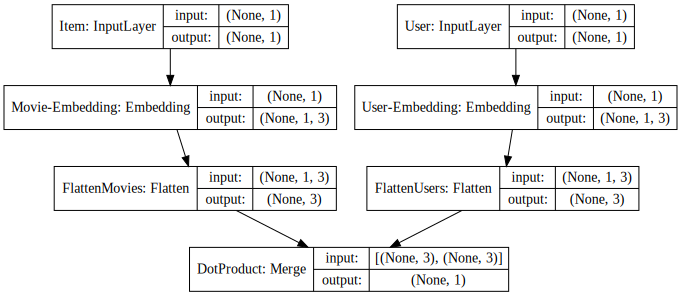

In [12]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

We can see that in the `Merge` layer, we take the dot product of the user and the item embeddings to obtain the rating.

We can also summarise our model as follows:

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         5049        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         2832        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

So, we have 7881 parameters to learn! Let's train our model now!

In [14]:
history = model.fit([train.user_id, train.item_id], train.rating, epochs=100, verbose=0)

#### Train error v/s epoch number

Before we test how well our model does in the test setting, we can visualise the train loss with epoch number.

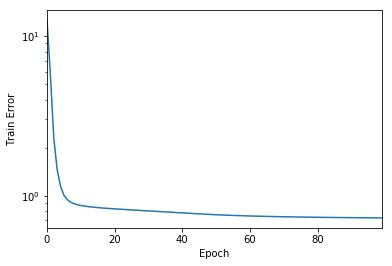

In [15]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

#### Prediction error

Let's now see how our model does! I'll do a small post-processing step to round off our prediction to the nearest integer. This is usually not done, and thus just a whimsical step, since the training ratings are all integers! There are better ways to encode this intger requirement (one-hot encoding!), but we won't discuss them in this post.

In [16]:
y_hat = np.round(model.predict([test.user_id, test.item_id]),0)
y_true = test.rating

In [17]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.69315000000000004

Not bad! We're able to get a $MAE$ of 0.69! I'm sure with a bit of parameter/hyper-parameter optimisation, we may be able to improve the results. However, I won't talk about these optimisations in this post. 

#### Extracting the learnt embeddings

We can extract the learnt movie and item embeddings as follows:

In [18]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,1683.000000,1683.000000,1683.000000
mean,-0.984843,-0.603969,1.041909
std,0.406160,0.670511,0.446950
min,-2.353670,-3.060338,-1.466393
25%,-1.274978,-1.112795,0.738104
50%,-0.990592,-0.631524,1.069417
75%,-0.705720,-0.123005,1.348613
max,0.412110,2.587206,3.013140


In [19]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2
count,944.000000,944.000000,944.000000
mean,-1.293906,-0.854671,1.216010
std,0.368389,0.631125,0.479045
min,-2.682317,-2.569576,-0.205914
25%,-1.528671,-1.283581,0.893250
50%,-1.305850,-0.931421,1.199088
75%,-1.077751,-0.508994,1.553708
max,0.377835,1.809386,3.263695


We can see that both the user and the item embeddings have negative elements. There are some applications which require that the learnt embeddings be non-negative. This approach is also called non-negative matrix factorisation, which we'll workout now.

### Non-negative Matrix factorisation (NNMF) in Keras

The code for NNMF remains exactly the same as the code for matrix factorisation. The only change is that we add `non-negativity` constraints on the learnt embeddings. This is done as follows:

In [20]:
from keras.constraints import non_neg
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='NonNegMovie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='NonNegUser-Embedding',embeddings_constraint=non_neg())(user_input))

prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

We now verify if we are indeed able to learn non-negative embeddings. I'll not compare the performance of NNMF on the test set, in the interest of space.

In [21]:
history_nonneg = model.fit([train.user_id, train.item_id], train.rating, epochs=10, verbose=0)

In [22]:
movie_embedding_learnt = model.get_layer(name='NonNegMovie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,1683.000000,1683.000000,1683.000000
mean,0.841644,0.842097,0.840586
std,0.296384,0.297492,0.296452
min,-0.000000,-0.000000,-0.000000
25%,0.650189,0.652484,0.649923
50%,0.895204,0.893022,0.889767
75%,1.073633,1.077216,1.071834
max,1.382212,1.375976,1.370250


Looks good!

### Neural networks for recommendation

We'll now create a simple neural network for recommendation, or for estimating rating! This model is very similar to the earlier matrix factorisation models, but differs in the following ways:

1. Instead of taking a dot product of the user and the item embedding, we concatenate them and use them as features for our neural network. Thus, we are not constrained to the dot product way of combining the embeddings, and can learn complex non-linear relationships.
2. Due to #1, we can now have a different dimension of user and item embeddings. This can be useful if one dimension is larger than the other.

In [80]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.merge([movie_vec, user_vec], mode='concat',name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

Let's now see how our model looks like:

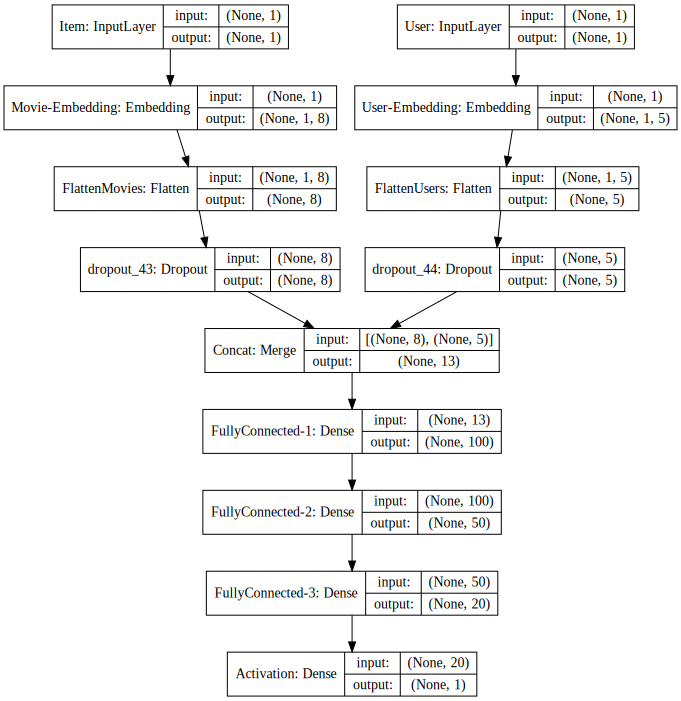

In [81]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

It should be noted that we use a different number of embeddings for user (3) and items (5)! These combine to form a vector of length (5+3 = 8), which is then fed into the neural network. We also add a dropout layer to prevent overfitting!

In [82]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         13464       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         4720        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

We can see that the number of parameters is more than what we had in the Matrix Factorisation case. Let's see how this model works. I'll run it for more epochs given that we have more parameters.

In [88]:
history = model.fit([train.user_id, train.item_id], train.rating, epochs=250, verbose=1)

Epoch 1/250
80000/80000 [==============================] - 4s 46us/step - loss: 0.6759
Epoch 2/250
80000/80000 [==============================] - 4s 46us/step - loss: 0.6794
Epoch 3/250
80000/80000 [==============================] - 4s 46us/step - loss: 0.6791
Epoch 4/250
80000/80000 [==============================] - 4s 46us/step - loss: 0.6741
Epoch 5/250
80000/80000 [==============================] - 4s 46us/step - loss: 0.6770
Epoch 6/250
80000/80000 [==============================] - 4s 46us/step - loss: 0.6769
Epoch 7/250
80000/80000 [==============================] - 4s 46us/step - loss: 0.6751
Epoch 8/250
80000/80000 [==============================] - 4s 46us/step - loss: 0.6788
Epoch 9/250
80000/80000 [==============================] - 4s 46us/step - loss: 0.6778
Epoch 10/250
80000/80000 [==============================] - 4s 46us/step - loss: 0.6753
Epoch 11/250
80000/80000 [==============================] - 4s 46us/step - loss: 0.6764
Epoch 12/250
80000/80000 [===============

KeyboardInterrupt: 

#### Prediction performance of Neural Network based recommender system

In [89]:
y_hat_2 = np.round(model.predict([test.user_id, test.item_id]),0)
print(mean_absolute_error(y_true, y_hat_2))

print(mean_absolute_error(y_true, model.predict([test.user_id, test.item_id])))




0.6993
0.715507672799


Pretty similar to the result we got using matrix factorisation. Maybe, we need to tweak around a lot more with the neural network to get better results?

Thanks for reading. This post has been a good learning experience for me. Hope you enjoyed too! 